<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/LogReg_remove_stopwords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymorphy2 --quiet

     |████████████████████████████████| 55 kB 1.8 MB/s 
     |████████████████████████████████| 8.2 MB 39.3 MB/s 


In [79]:
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

In [68]:
data = pd.read_csv('https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_original_RU.csv')
data.sample(10)

,comment,toxic
8897,Рабочий день впереди)\n,0.0
10725,Ну так непонимание с моей стороны возникло име...,0.0
10235,У каждого банка на сайте есть список аккредито...,0.0
4089,Только почему-то почти в каждом обычном городе...,0.0
10560,И бесплатно заметим. Хотя работающие люди мень...,0.0
2204,"Я его не смотрел последние месяца 3, так что н...",0.0
5483,"Возможно, но считаю, что пытаться наказать вод...",0.0
9360,А во взрывпакетах? Помню все таки был...\n,0.0
13789,поскольку по статистике более 50 преступлений ...,0.0
4618,"Прикольный парк, 5 фото и 4 из них про жизнеде...",0.0


In [69]:
data['comment'] = data['comment'].values.astype('U')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


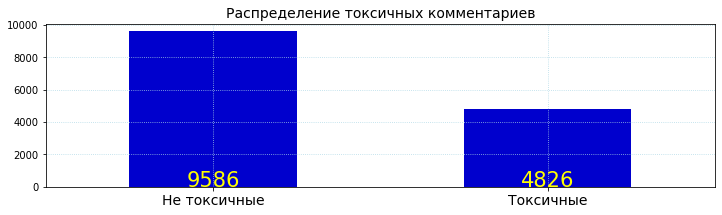

In [70]:
fig, ax = plt.subplots(figsize=(12, 3))

toxic = (data['toxic'].value_counts()).plot(kind='bar',  
                                   color='mediumblue').set_title(
    'Распределение токсичных комментариев', 
    fontdict={'fontsize': 14}
)
ax.set_xticklabels(['Не токсичные', 'Токсичные'], rotation=0, fontsize=14, )
plt.grid(color='lightblue', linestyle=':')
plt.text(0, 1, (data['toxic'].value_counts())[0], horizontalalignment='center', fontsize=21, color='yellow')
plt.text(1, 1, (data['toxic'].value_counts())[1], horizontalalignment='center', fontsize=21, color='yellow')
plt.show()

In [6]:
print('Количество дубликатов -', data.duplicated().sum())

Количество дубликатов - 0


In [71]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [72]:
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['это', 'нею'])
stopwords = set(russian_stopwords)

In [73]:
morph = pymorphy2.MorphAnalyzer()
def lemmatize_word(word: str) -> str:
    try:
        p = morph.parse(word)[0]
        return p.normal_form 
    except:
        return word

In [74]:
def clear_and_lemmatize_text(text):
    text= text.lower()
    clear = re.sub(r'[^а-яА-ЯёЁ]', ' ', text) # все кроме букв
    clear = re.sub(r"\s+[а-яА-ЯёЁ]\s+", ' ', clear) # одиночные буквы
    clear = re.sub(r'\s+', ' ', clear) # лишние пробелы
    text_tokens = word_tokenize(clear)
    return ' '.join([lemmatize_word(word) for word  in text_tokens if word not in stopwords])

In [77]:
%%time
data['comment'] = data['comment'].apply(clear_and_lemmatize_text)

CPU times: user 34.6 s, sys: 86.5 ms, total: 34.7 s
Wall time: 34.7 s


In [80]:
data['comment'].replace('', np.nan, inplace=True)
data.dropna(subset=['comment'], inplace=True)

In [81]:
data.sample(10)

,comment,toxic
6194,дебил бля гугл хуйня обучать нейросетка автопилот,1.0
6574,уличный драка школа говорить помещение балончи...,0.0
9091,вообще жаль продавец,0.0
4499,предложение подписать свой аккума номер телефо...,0.0
9068,ощущение новый сцепление пропасть день норма п...,0.0
2401,ларин очень хороший известный среди питурд узк...,0.0
4393,чувак кабзд удивиться руль хачёныш рашка свой ...,1.0
2971,чистить каждый минута начинать год манька это ...,1.0
2594,объяснить клоун разосраться себя,1.0
7476,сделать шлем открытый выделяться среди другой ...,0.0


In [84]:
FILE_NAME_CLEAR_DATA='data_cleaned_RU_remove_stopwords.csv'
data=data.astype({'toxic': 'int64'})
data.to_csv(FILE_NAME_CLEAR_DATA, encoding='utf-8', index=False)
# files.download(FILE_NAME)

**Загружаем ощищенные данные**

In [85]:
url='https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_cleaned_RU_remove_stopwords.csv'
df = pd.read_csv(url)
df.sample(10)

,comment,toxic
5173,напомнить серия пожалуйста заранее спасибо,0
977,оскар мерзкий шовинистический свинья раса раса...,1
11549,сколько постить дерьмо,1
691,судить человек внешний вид одежда тот говорить...,1
1341,правильно говорить система должный мера мера о...,0
9434,отчисление страховка который идти покрытие сто...,0
11575,смотреть доктор хаус мочь начинать завидовать,1
13417,вообще понимать разрешать смс короткий номер с...,0
4240,цинизм человек хотеть соблюдение социальный фу...,0
2216,справедливо переехать мразот такой причёска по...,1


**Взвесим tf-idf**

In [86]:
count_idf_neutral = TfidfVectorizer(min_df=3, max_df=0.8)
count_idf_toxic = TfidfVectorizer(min_df=3, max_df=0.8)

tf_idf_neutral = count_idf_neutral.fit_transform(df.query('toxic == 0')['comment'])
tf_idf_toxic = count_idf_toxic.fit_transform(df.query('toxic == 1')['comment'])

In [87]:
# Сохраним списки Idf для каждого класса
neutral_importance = pd.DataFrame(
    {'word' : count_idf_neutral.get_feature_names_out(),
     'idf' : count_idf_neutral.idf_
    }).sort_values(by = 'idf', ascending = False)

toxic_importance = pd.DataFrame(
    {'word' : count_idf_toxic.get_feature_names_out(),
     'idf' : count_idf_toxic.idf_
    }).sort_values(by = 'idf', ascending = False)

In [88]:
neutral_importance.head(10) 

,word,idf
0,аба,8.781139
3447,некогда,8.781139
3429,нежный,8.781139
3431,независимость,8.781139
3435,незаметно,8.781139
3436,незнакомый,8.781139
3437,незнать,8.781139
3441,неизменный,8.781139
3442,неинтересный,8.781139
3444,нейросеть,8.781139


In [89]:
toxic_importance.head(10)

,word,idf
0,аборт,8.095064
926,жесть,8.095064
2474,подонок,8.095064
2479,подписывать,8.095064
950,жёлчь,8.095064
2484,подрочить,8.095064
946,журналистика,8.095064
2490,подстилка,8.095064
2491,подтвердить,8.095064
2493,подтирать,8.095064


**Разделение выборок, преобразование текстов**

In [90]:
X_train, X_test, y_train, y_test = train_test_split(df['comment'], df['toxic'], test_size=.2, random_state=7)

**Векторизация текста**

In [91]:
vectorize = TfidfVectorizer(min_df=3, max_df=0.8)

In [92]:
# рассчитываем TF-IDF слов
X_train = vectorize.fit_transform(X_train)
X_test = vectorize.transform(X_test)

**LogisticRegression**

In [93]:
clf = LogisticRegression(solver = 'lbfgs',
                                    random_state = 21,
                                    max_iter= 10000,
                                    n_jobs= -1)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=21)

**Save model**

In [94]:
import joblib
joblib_file = "LogisticRegressionModel.pkl"
joblib.dump(clf, joblib_file)

# Load from file
joblib_model = joblib.load(joblib_file)

# Calculate the accuracy and predictions
score = joblib_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = joblib_model.predict(X_test)

Test score: 85.60 %


In [95]:
pred = clf.predict(X_test)

**Отобразим матрицу ошибок**

In [96]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(y_test, pred)))
  print("Recall: {0:.2f} %".format(100 * recall_score(y_test, pred)))
  print("Precision: {0:.2f} %".format(100 * precision_score(y_test, pred)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(y_test, pred)))  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 85.60 %
Recall: 64.17 %
Precision: 89.67 %
F1-score: 74.80 % 

True Negatives:  1850
False Positives:  71
False Negatives:  344
True Positives:  616


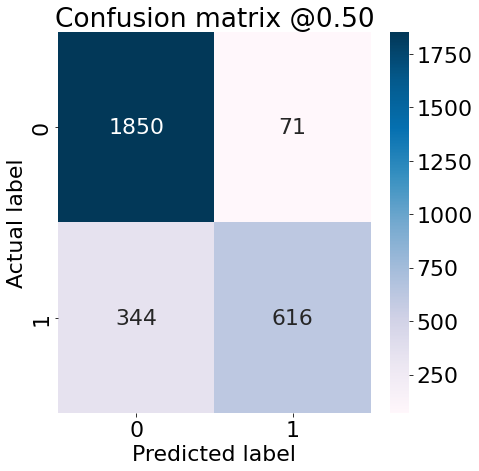

In [97]:
plot_cm(y_test, pred)

In [98]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1921
           1       0.90      0.64      0.75       960

    accuracy                           0.86      2881
   macro avg       0.87      0.80      0.82      2881
weighted avg       0.86      0.86      0.85      2881



**Отобразим ROC - кривую**

LogisticRegression: ROC AUC=0.927


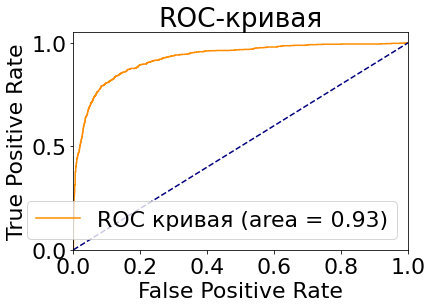

In [99]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
# сохраняем вероятности только для положительного исхода
lr_probs = clf.predict_proba(X_test)[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

#**Отобразим топ нейтральных и токсичных слов в текстах датасета**

In [100]:
def wordplot(txt_toxic, txt_neutral):
    
    txt_toxic=' '.join(txt_toxic)
    txt_neutral=' '.join(txt_neutral)

    fig, axs = plt.subplots(figsize=(20, 12))
    plt.axis('off')
    ax = fig.add_subplot(1, 2, 1)

    WIDTH=1600
    HEIGHT=1600
    
    wordcloud = WordCloud(width=WIDTH,
                          height=HEIGHT,
                          background_color="black",
                          colormap = 'Blues',
                          max_words=200,
                          mask=None
                          ).generate(txt_neutral)
    plt.axis('off')

    FONTSIZE=21
    INTERPOLATION='bilinear'

    plt.imshow(wordcloud, interpolation=INTERPOLATION)
    plt.title('NEUTRAL \n', fontsize=FONTSIZE)
    plt.margins(x=1, y=1)

    ax = fig.add_subplot(1, 2, 2)
    wordcloud = WordCloud(width=WIDTH,
                          height=HEIGHT,
                          background_color="black",
                          colormap = 'Oranges',
                          max_words=200,
                          mask=None, 
                          ).generate(txt_toxic)
    
    plt.imshow(wordcloud, interpolation=INTERPOLATION)
    plt.title('TOXIC \n', fontsize=FONTSIZE)
    plt.margins(x=1, y=0)
    plt.axis('off')
    plt.show()

In [102]:
feature_to_coef = { word: coef for word, coef in zip(vectorize.get_feature_names_out(), clf.coef_[0]) }

toxic, neutral   = [], []

for best_negative in sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:50]:
    toxic.append(best_negative[0])

for best_positive in sorted(feature_to_coef.items(), key=lambda x: x[1])[:50]:
    neutral.append(best_positive[0])

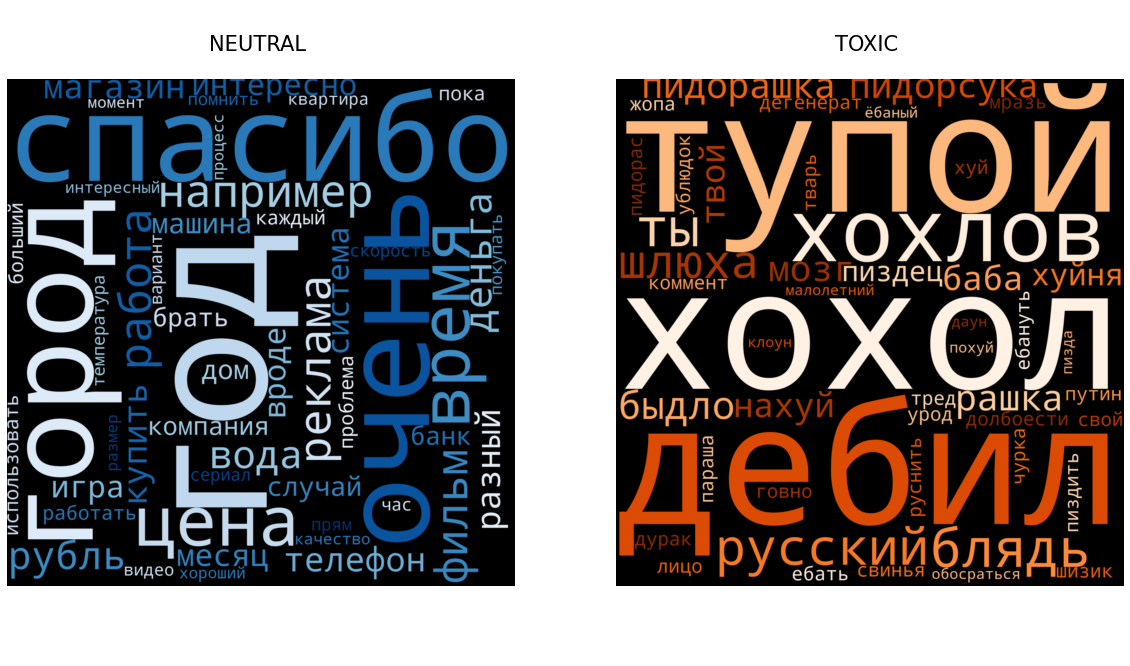

In [103]:
wordplot(toxic, neutral)